<a href="https://colab.research.google.com/github/francescomontagna/Quantum-Reinforcement-Learning/blob/main/QuantumRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [93]:
import time
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Introduction
## Problems
- Since we can access the features, and know the transition probability from a state to another, this RL protocol is model based.
Note that this is in contrast with the uncertainty about a quantum state from the observator point of view: an observator can only access the collapsed state, having no access to the amplitudes. 

Can I mentally assume the agent to be the system under study itself? Or this is completely unreasonale? 

In the paper Girolami sent me, they explicitly account for this fact, setting up a model free protocol.  

- With features defined as amplitude (at the moment looks the only one reasonable, but has model-based problem + the one I am introducing) we have the problem that `np.matmul(self._W, state)` is an array of complex.  
How can I do `np.argmax(complex_array)`? I can not.  
One possible solution is to use the absolute over each element, but I am not sure...


## Reward
In Girolami's paper the used

\begin{equation}
r(t) = \begin{cases}
0, \;\; if \;\;t < T\\
F(T) = |<\psi^*| |\psi>| , \;\; if \;\;t = T\\
\end{cases}
\end{equation}

This notion is not applicable to my case to determine the terminal state, since I do not have a time stape T associated to it. But the use of fidelity is justified.

# Quantum Setup

### Qubit

In [2]:
class Qubit:
  def __init__(self, amplitudes):
    """
    Args:
      amplitudes (np.array): amplitudes of the |0>, |1> vectors
    """
    error = "Error: sum of squared amplitudes must be = 1"
    assert math.isclose(reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes)), 1, rel_tol = 1e-2), error
    self._amplitudes = amplitudes

  def qubit(self):
    return self._amplitudes
    

class Basis(Qubit):
  def __init__(self, index):
    """
    Args:
      index: index of the position = 1
    """
    amplitudes = np.zeros((2, ))
    amplitudes[index] += 1
    super().__init__(amplitudes)

### Quantum State

In [234]:
class QuantumState:
  def __init__(self, amplitudes): 

    # We assume computational basis
    self._basis = {
        '00': [Basis(0), Basis(0)],
        '01': [Basis(0), Basis(1)],
        '10': [Basis(1), Basis(0)],
        '11': [Basis(1), Basis(1)],
    }

    a1, a2, a3, a4 = amplitudes
    self._amplitudes = {
        '00': a1,
        '01': a2,
        '10': a3,
        '11': a4
    }
    
    self._keys = list(self._basis.keys())

    error = "Error: sum of squared amplitudes must be = 1"
    assert math.isclose(reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes)), 1, rel_tol = 1e-2), error


  def get_amplitudes(self):
    return np.array(list(self._amplitudes.values()))


  def apply_gate(self, gate, inplace = False):
    updated_amplitudes = gate.apply(self)
    if inplace:
      self._amplitudes = updated_amplitudes
      return None

    return QuantumState(list(updated_amplitudes.values()))

  def fidelity_score(self, other):
    # TODO: check on nielsen, implement well.
    # This implementation is from paper
    """
    Args:
      other (QuantumState): measure the fidelity between self and another quantum state
    Return:
      fidelity (float): fidelity score between [0, 1]
    """
    # Inner product can be computed in terms of matrix representation. Page 67 Nielsen-Chuang
    return np.square(abs(np.matmul(np.conj(self.get_amplitudes()), other.get_amplitudes())))

### Quantum Gates

In [4]:
class QuantumGate:
  def __init__(self, name, unitary, target):
    """
    Args: 
      unitary: 2x2 unitary operator
      target: 0 or 1 to denote the qubit the matrix is acting on
    """
    self._name = name
    self._U = unitary.flatten()
    self._target = target


  def apply(self, quantum_state):
    """
    Args:
      quantum_state (QuantumState): quantum state to which apply the quantum operator
    Return:
      updated (dict): didctionary with updated amplitudes
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._target == 0:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = self._U[2]*a_00 + self._U[3]*a_10
      updated['11'] = self._U[2]*a_01 + self._U[3]*a_11

    else:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_01
      updated['01'] = self._U[2]*a_00 + self._U[3]*a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated


class CNOT(QuantumGate):
  def __init__(self, control):
    """
    Args:
      control (int): if 0, first qubit is the control, else second
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    self._control = control
    super().__init__('cnot', np.array([[0, 1], [1, 0]]), 1-control)


  def apply(self, quantum_state):
    """
    Args:
      state (QuantumState): quantum state to which apply the quantum operator
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._control == 0: # Then target = 2nd: if 1st qubit == 1, flip 2nd qubit.
      updated['00'] = a_00
      updated['01'] = a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    if self._control == 1: # Then control = 1st: if 2nd qubit == 1, flip 1st qubit.
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = a_10
      updated['11'] = a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated

### Gates List

In [104]:
# Why don't I implement universal gates only?
# TODO: compare results with qiskit
class Gates:
  def __init__(self):
    gates = dict()
    self._num_gates = 0

    # Useful
    targets = [0, 1]
    j = 1j # complex unit

    ########### CNOT ###########
    gates['CNOT'] = CNOT(control = 0)
    self._num_gates += 1

    ########### Rotations ###########
    angles_names = ['pi', '2pi/3', 'pi/2', 'pi/3', 'pi/4']
    angles_values = (math.pi / 2) * np.array([1, 2/3, 1/2, 1/3, 1/4])
    angles = {k:v for k,v in zip(angles_names, angles_values)}

    # X
    for name, theta in angles.items():
      for t in targets:
        key = 'Rx' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -j*math.sin(theta)],
                                                      [-j*math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1
        
    # Y
    for name, theta in angles.items():
      for t in targets:
        key = 'Ry' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -math.sin(theta)],
                                                      [math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1

    # Z
    for name, theta in angles.items():
      for t in targets:
        key = 'Rz' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[cmath.exp(-j*theta), 0],
                                                      [0, cmath.exp(j*theta)]]), t)
        self._num_gates += 1

    self._gates_list = list(gates.keys())
    self._gates = list(gates.values())

  def num_gates(self):
    return self._num_gates

In [ ]:
gates = Gates()

# Make several simulations and compare results with qiskit
q = QuantumState(np.array([0.4j, 0.3, 0.6, 0.624]))
old_amplitudes = q.get_amplitudes()
for g, name in zip(gates._gates, gates._gates_list):
  print("Gate " + name)
  q.apply_gate(g, inplace = True)
  new_amplitudes = []
  for val in q.get_amplitudes():
    new_amplitudes.append("{:.3}".format(val))

  print("Applied gate " + name + f" to qubit with amplitudes {old_amplitudes}.\n" +
        f"Updated amplitudes: {new_amplitudes}")
  
  print("\n\n")

# RL Setup

## Environment

In [357]:
# LinearModel of the environment
class LinearModel:
  def __init__(self, initial_state, target_state, tolerance):
    """
    Args:
      initial_state (QuantumState): initial state of the system
      target_state (QuantumState): target state of the system
      tolerance (float): tolerance in terms of fidelity score
    """
    self._initial_state = initial_state
    self._target_state = target_state
    self._tolerance = tolerance # tolerance in terms of fidelity between
    self._quantum_gates, self._gates_list, self._num_gates = self.gates_set()
    self._terminal_fidelity = 0 # used to retrieve the info at the end of an episode
    self._terminal_state = initial_state # used to retrieve the info at the end of an episode
    
    # Used to initialize env from scratch.
    self.reset() 

    assert initial_state.fidelity_score(target_state) < (1-tolerance), f"The two state are the same up to {tolerance} tolerance"

    
  def gates_set(self):
    """
    Returns:
      gates._gates (List[QuantumGate]): return the list with available QuantumGate objects
      gates._gates_list (List[String]): list with the name of available gates
    """
    gates = Gates()
    return gates._gates, gates._gates_list, gates.num_gates()

  def step(self, action):
    """
    Given a gate, apply it to self._state.
    Set the reward, resulting state and discount.
    Return these values, along with the information if therminal state has been reached
    Args:
      action (int): action index to select a QuantumGate

    Return:
      reward, discount, next_state features, terminal
    """
    # Get and apply action. next_state is a QuantumState
    gate = self._quantum_gates[action]
    next_state = self._state.apply_gate(gate)

    # Compare new state and target
    fidelity = next_state.fidelity_score(self._target_state)

    # Assign reward based on state and fidelity
    terminal = self.is_terminal(fidelity)

    # Terminal state
    if terminal:
      reward = +100.
      discount = 0.
      self._terminal_fidelity = fidelity
      self._terminal_state = next_state
      self.reset()

    # Degradation
    elif fidelity <= self._current_fidelity:
      reward = 0
      discount = 0.9
      self._current_fidelity = fidelity
      self._state = next_state

    # Improvement
    else:
      reward = 0
      discount = 0.9
      self._current_fidelity = fidelity
      self._state = next_state

    # Return the features, not the state itself
    return reward, discount, self._state.get_amplitudes(), terminal


  def is_terminal(self, fidelity):
    """
    Check if, by a level of self.tolerance, state is terminal
    """
    if fidelity > (1 - self._tolerance):
      return True

    return False


  def get_features(self):
    return self._state.get_amplitudes()


  def reset(self):
    self._state = self._initial_state
    self._current_fidelity = 0

## Agent
There is a bug I think, when I provide as next_state the initial state I
- agent is in state self._state: a state contiguous to the terminal one, T, that we call S
- the update is done for S wrt to next_state, which in this case is I, and not T as expected. There are 2 major drawbacks as consequence  
One is that the update is done wrongly: r + g*q(I), but I here has not any sense
Two is that I will never learn that this state is contiguous.

Now, I have to reason about this, because I think in the assignment they used this approach, but better to write down this doubt.

NO! This issue is fixed by putting discount = 0. Alright :)

In [316]:
# Least Square TD Agent: action value function approximation
# implemented with gradient descent.
class LSTDAgent:
  def __init__(self, number_of_actions, number_of_features,
      initial_state, step_size, eps):
    """
    Args:
      initial_state: it is a feature vector!
    """
    self._number_of_actions = number_of_actions
    self._W = np.zeros((number_of_actions, number_of_features), dtype = 'complex128')
    self._step_size = step_size
    self._eps = eps
    self._state = initial_state
    self._action = np.argmax(self.q(initial_state))

  def eps_greedy(self, state):
    """
    Args:
      state (list): list of the amplitudes := features of the state
    """
    greedy = np.random.choice([True, False], p = (1-self._eps, self._eps))
    if greedy:
      return np.argmax(self.q(state))

    return random.choice(range(self._number_of_actions))

  def q(self, state):
    """
    Args:
      state (list): list of the amplitudes := features of the state
    """
    # Features are complex... How to determine the value function? Absolute value?
    # This is a big issue
    # TODO: review! Chiedo anche a Davide
    return np.absolute(np.matmul(self._W, state))

  def step(self, reward, discount, next_state):
    """
    Args:
      next_state (list): list of the amplitude: these are already features, not a QuantumState instance
      terminal (boolean): if next_state is the terminal state
    """
    s = self._state
    a = self._action
    r = reward
    next_s = next_state
    g = discount

    # Update weights for current state action. If next state
    next_a = self.eps_greedy(next_s)
    # WARNING: If s is complex, also the update become complex ... Can I decide to have complex weights?
    self._W[a] += self._step_size * (r + g * self.q(next_s)[next_a] - self.q(s)[a]) * s

    self._action = next_a
    self._state = next_s

    return next_a

# Helper Functions
Class to handle experiments and visualization
- run experiment
- Allow for agent.q visualization for a state, providing labels to actions. This allow to see if very close states are associated to very close actions
- Monitor number of steps as experience grow: is the agent actually learning good?
- Monitor the weights (see if I can find any meaning): need to put labels about actions ==> does an action focuses on an amplitudes subset as I would expect (e.g. if an amplitude is not touched by  gate, than I expect its weight value to be low
- Monitor q value on 2D graphs (choose a subset of amplitudes).
- Monitor fidelity score inside episodes
- Monitor impact of initial gate


In [247]:
# Facade
class Experiment:
  def __init__(self, start_state, target_state, tolerance, number_of_episodes, step_size, eps, verbose = 0.1):

    self._env = LinearModel(QuantumState(start_state), QuantumState(target_state), tolerance)

    number_of_actions = len(self._env._gates_list)
    initial_features = self._env.get_features()

    self._agent = LSTDAgent(number_of_actions, len(initial_features), initial_features,
                            step_size, eps)
    
    self._number_of_episodes = number_of_episodes

    self._episodes_gates = [] # check disrtribution of gates in different solutions
    self._mean_rewards = [] # list of mean reward for each episode

    self._verbose = verbose


  def run_experiment(self):
    """
    Run episodes, gathering statistics and updating user on conosole.
    """
    for episode in range(self._number_of_episodes):
      gates, mean_reward = self.run_episode()
      if (np.random.choice([True, False], p = [self._verbose ,1-self._verbose])):
        print(f"Episode {episode}: completed in {len(gates)} steps. Fidelity score: {self._env._terminal_fidelity}")
      self._mean_rewards.append(mean_reward)
      self._episodes_gates.append(gates)

    return mean_rewards, self._episodes_gates

  def run_episode(self):
    """
    Run a single episode.
    At the beginning of an episode we must guarantee
    - initial state in the environment
    - initial state in the agent
    """
    terminal = False
    action = agent._action
    gates = [action]
    mean_reward = 0
    i = 0
    while not terminal:
      reward, discount, next_s, terminal = self._env.step(action)
      action = self._agent.step(reward, discount, next_s)

      i += 1
      mean_reward += (reward - mean_reward)/i
      gates.append(action)
    return gates, mean_reward

# Experiment

In [360]:
TOLERANCE = 0.2
NUM_EPISODES = 100
STEP_SIZE = 0.001
EPS = 0.2

In [363]:
start = [0.1j, 0.1, 0.1, -0.985]
target = [0.5, 0.5, 0.5, 0.5]
experiment = Experiment(start, target, TOLERANCE, NUM_EPISODES, STEP_SIZE, EPS)
mean_rewards, gates_sequences = experiment.run_experiment()
len_sequences = list(map(lambda x: len(x), gates_sequences))
print(len_sequences)
print(np.mean(len_sequences[-int(len(len_sequences)//10):]))

Episode 10: completed in 6 steps. Fidelity score: 0.8006184059016866
Episode 12: completed in 6 steps. Fidelity score: 0.8006184059016866
Episode 18: completed in 63 steps. Fidelity score: 0.8838670597052964
Episode 25: completed in 22 steps. Fidelity score: 0.9190981336475424
Episode 45: completed in 8 steps. Fidelity score: 0.9551521216744561
Episode 57: completed in 6 steps. Fidelity score: 0.8006184059016866
Episode 67: completed in 60 steps. Fidelity score: 0.8312675871541854
Episode 82: completed in 7 steps. Fidelity score: 0.8006184059016866
Episode 98: completed in 6 steps. Fidelity score: 0.8006184059016866
[2484, 1519, 209, 15, 145, 23, 9, 6, 43, 212, 6, 6, 6, 6, 6, 8, 7, 9, 63, 6, 8, 225, 6, 5, 6, 22, 15, 7, 6, 6, 18, 6, 10, 6, 5, 6, 9, 6, 5, 6, 6, 6, 8, 6, 8, 8, 10, 6, 6, 7, 7, 6, 58, 6, 9, 22, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 60, 6, 73, 6, 6, 6, 20, 6, 8, 8, 6, 41, 9, 7, 7, 7, 7, 8, 185, 43, 7, 1047, 6, 6, 6, 8, 6, 73, 6, 8, 8, 6, 14]
14.1


In [ ]:
np.array(gates_sequence)

In [319]:
cnot = CNOT(control=0)
psi = QuantumState([0.1j, 0.1, 0.1, -0.985])
psi.apply_gate(cnot).get_amplitudes()

array([ 0.   +0.1j,  0.1  +0.j , -0.985+0.j ,  0.1  +0.j ])

In [350]:
experiment._agent.q([ 0.+0.1j,  0.1+0.j ,-0.985+0.j ,0.1  +0.j ])

array([0.0031857 , 0.00330024, 0.00202958, 0.00098402, 0.00135166,
       0.00135311, 0.00110261, 0.00726727, 0.0015579 , 0.00799947,
       0.00454783, 0.01282572, 0.00121933, 0.00189539, 0.03903053,
       0.00764284, 0.00204736, 0.01130368, 0.02264428, 0.01633613,
       0.00223812, 0.01900089, 0.08760227, 0.0019147 , 0.0260316 ,
       0.03622193, 0.00439654, 0.15853803, 0.00516891, 0.00417793,
       0.00708669])

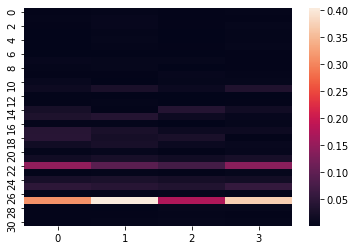

In [349]:
sns.heatmap(np.absolute(experiment._agent._W))

In [114]:
agent.q([0.1, 0.1, 0.1, 0.985])

array([0.87628675, 0.34965576, 0.12456508, 0.19295795, 0.18540797,
       0.11813284, 0.48388044, 0.64085723, 0.23277671, 0.29359042,
       0.44233488, 0.85342113, 0.12654838, 0.49933601, 0.77422928,
       0.09018279, 0.36215249, 0.53098625, 0.85408517, 0.33237465,
       0.52862498, 0.53005734, 1.4881167 , 0.60855694, 0.29885098,
       0.47356818, 0.39647692, 0.93295223, 0.84030677, 0.7036489 ,
       1.51046609])

In [113]:
# Plot results for every element in the grid
episodes_length = []
for gate in gates_sequence[-100:]:
  episodes_length.append(len(gate))

np.mean(episodes_length)

205.6

In [276]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid({'eps': [0.4, 0.5, 0.6, 0.7, 0.8], 'step_size': [0.001, 0.01, 0.05, 0.1, 0.3]})

In [ ]:
# TODO: for each episode monitor fidelity trend ==> is there learning or is it random?
for params in grid:
  eps = params['eps']
  step_size = params['step_size']
  start = [0.1, 0.1, 0.1, 0.985]
  target = [0.5, 0.5, 0.5, 0.5]
  env = LinearModel(QuantumState(start), QuantumState(target), TOLERANCE)
  agent = LSTDAgent(env._num_gates, 4, env.get_features(), step_size, eps)
  mean_rewards, gates_sequence = run_experiment(env, agent, NUM_EPISODES)

In [271]:
# Plot results for every element in the grid
episodes_length = []
for gate in gates_sequence:
  episodes_length.append(len(gate))

In [272]:
np.mean(episodes_length)

322.58